# Spectroscopic Lensing: Noise Test


## Imports and Functions

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG

import redrock.templates
import redrock.results
from redrock.external import desi
 
from desi_myfunctions import *

import time

%matplotlib inline
sns.set(context='talk', palette='Dark2')

In [3]:
start = time.time()

In [4]:
def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd

In [5]:
def setlims(x, y):
    
    if max(x) > max(y):
        maximum = max(x) + 0.2
    
    if max(x) < max(y):
        maximum = max(y) + 0.2
    
    if min(x) > min(y):
        minimum = min(y) - 0.2
    
    if min(x) < min(y):
        minimum = min(x) - 0.2
        
    lims = (minimum, maximum)
    
    return lims

## Simulate and Combine Spectra

In [6]:
fratio = 0.1
BGSmag = 20
ELGseed = 50
BGSseed = 79
nrShifts = 10
ELGmag = maggen(BGSmag, fratio)

wave, flux, BGSmeta, ELGmeta = combspec(BGSmag=BGSmag, ELGmag=ELGmag, ELGseed=ELGseed, BGSseed=BGSseed, nrShifts=nrShifts, returnmeta=True)

INFO:io.py:966:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:966:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits


In [7]:
fileloc = os.path.join(os.getenv('HOME'), 'specLensing', 'fitsfiles', 'noiseTest')
fitsfile = 'combined_spectra_data.fits'

writefits(fileloc, fitsfile, wave, 'Angstrom', hdrname='Wavelength', overwrite=True)
writefits(fileloc, fitsfile, flux, '10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=True)

## Create Different Noise levels of Spectra

In [8]:
infile = os.path.join(fileloc, fitsfile)
lownoise = os.path.join(fileloc, 'low_noise')
mednoise = os.path.join(fileloc, 'med_noise')
highnoise = os.path.join(fileloc, 'high_noise')

cmd = 'quickspectra -i {} -o {} --seeing 1.1 --airmass 1.1 --exptime 1000'.format(infile, lownoise)
chkfile(cmd, lownoise)

cmd = 'quickspectra -i {} -o {} --seeing 1.1 --airmass 1.1 --exptime 200'.format(infile, mednoise)
chkfile(cmd, mednoise)

cmd = 'quickspectra -i {} -o {} --seeing 1.1 --airmass 1.1 --exptime 1'.format(infile, highnoise)
chkfile(cmd, highnoise)

In [9]:
sn = []
noise = [lownoise, mednoise, highnoise]

for file in noise:
    
    s = desispec.io.read_spectra(file)
    ivar = s.ivar
    snflux = s.flux

    snrs = []
    for band in s.bands:

        allsn = snflux[band] * np.sqrt(ivar[band])
        snrs.append(allsn)

    snr = []
    for lis in snrs:

        lis = np.concatenate(lis)
        snr.append(lis)

    snr = np.concatenate(snr)
    onesn = np.median(snr)
    sn.append(onesn)

sn = np.round(sn, decimals=4)

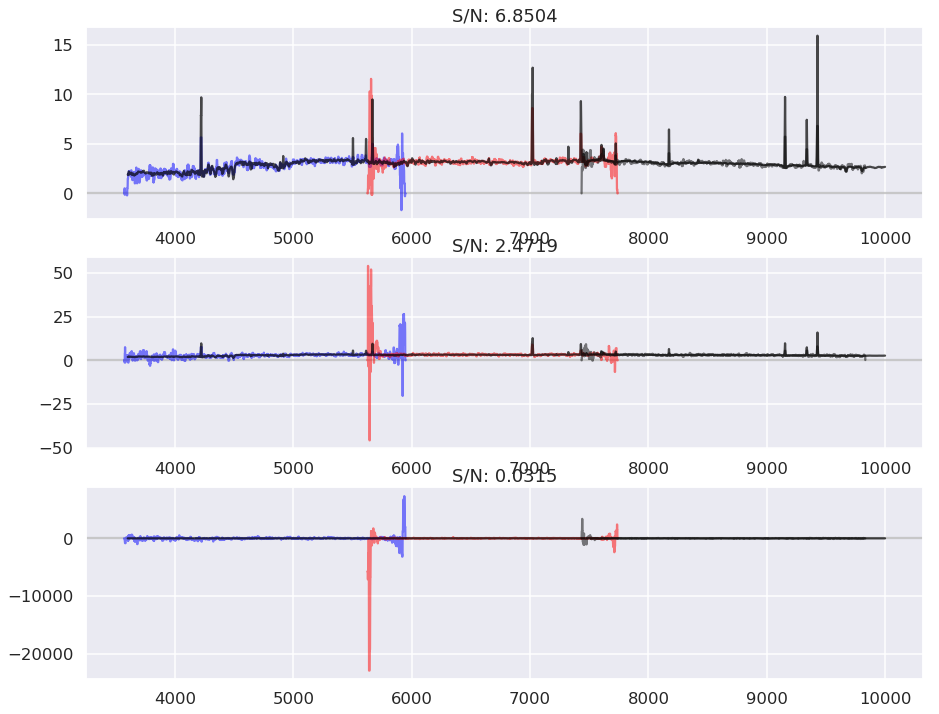

In [10]:
target = 1

fig, ax = plt.subplots(3,1,figsize=(15,12))

for i in range(len(ax)):
    
    plotobsspectra(noise[i], target, ax=ax[i], trueflux=flux, truewave=wave)
    ax[i].title.set_text('S/N: {}'.format(sn[i]))

# Run Redrock to extract templates

In [11]:
zfiles = []
h5files = []

noisefiles = [lownoise, mednoise, highnoise]

for file in noisefiles:
    
    zfile = os.path.join(os.path.splitext(file)[0] + '_rr.fits')
    h5file = os.path.join(os.path.splitext(file)[0] + '_rrh5.h5')
    
    cmd = 'rrdesi {} -z {} -o {}'.format(file, zfile, h5file)
    chkfile(cmd, zfile)
    
    zfiles.append(zfile)
    h5files.append(h5file)

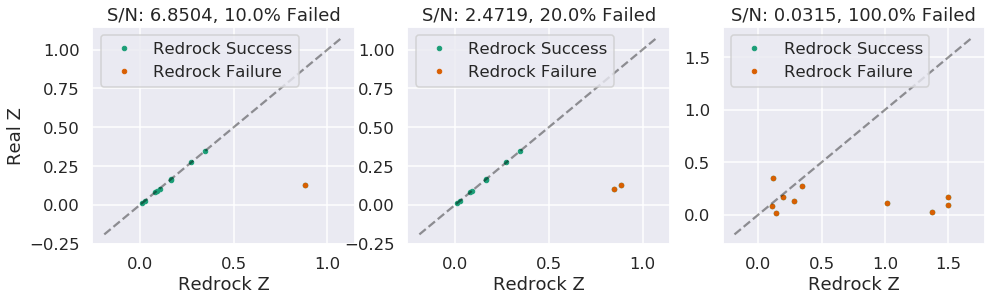

In [12]:
BGSz = BGSmeta['REDSHIFT']

zbests = []

fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_ylabel('Real Z')

for ii in range(len(zfiles)):
    
    zdata = Table.read(zfiles[ii], 'ZBEST')
    zbests.append(zdata)
    
    zdata['dz'] = zdata['Z'] - BGSz
    rrfail = np.where(np.abs(zdata['dz']) > 0.003)[0]
    failrate = len(zbests[ii][rrfail]) / len(zbests[ii])
    
    dlim = setlims(zdata['Z'], BGSz)
    
    ax[ii].plot(zdata['Z'], BGSz, '.', label='Redrock Success')
    ax[ii].plot(zdata['Z'][rrfail], BGSz[rrfail], '.', label='Redrock Failure')
    ax[ii].title.set_text('S/N: {}, {}% Failed'.format(sn[ii], failrate*100))
    ax[ii].set_xlabel('Redrock Z')
    ax[ii].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
    ax[ii].legend()

In [13]:
for ii in range(len(zbests)):
    
    zbests[ii]['dz'] = zbests[ii]['Z'] - BGSz
    
    rrfail = np.where(np.abs(zbests[ii]['dz']) > 0.003)[0]
    
    failrate = len(zbests[ii][rrfail]) / len(zbests[ii])
    
    print('{}% of {} Failed'.format(failrate*100, zfiles[ii][len(fileloc)+1:-8]))

10.0% of low_noise Failed
20.0% of med_noise Failed
100.0% of high_noise Failed


## Subtract and Run through Redrock again

In [14]:
specfiles = []

for ii in range(len(zfiles)):

    specfiles.append(rrtemp_to_spectra(noisefiles[ii], zbest=zbests[ii]))

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


In [16]:
lowzfiles = {'Z': [], 'h5': []}
medzfiles = {'Z': [], 'h5': []}
highzfiles = {'Z': [], 'h5': []}

lis = [lowzfiles, medzfiles, highzfiles]
num = np.arange(0, len(specfiles[0]))

for i in range(len(specfiles)):
    
    for k in range(len(specfiles[i])):
        
        infile = specfiles[i][k]
        zoutfile = os.path.join(fileloc, 'residual-z-out-{}-{}.fits'.format(zfiles[i][len(fileloc)+1:-8], num[k]))
        h5outfile = os.path.join(fileloc, 'residual-h5-out-{}-{}.h5'.format(zfiles[i][len(fileloc)+1:-8], num[k]))
        
        cmd = 'rrdesi {} -o {} -z {}'.format(infile, h5outfile, zoutfile)      
        chkfile(cmd, zoutfile)
        
        lis[i]['Z'].append(zoutfile)
        lis[i]['h5'].append(h5outfile)                              

In [17]:
reszbests = []

for dic in lis:
    
    dic['tables'] = []
    
    for file in dic['Z']:
    
        zbest = Table.read(file, 'ZBEST')
        dic['tables'].append(zbest)
        
    zbest = vstack(dic['tables'])
    reszbests.append(zbest)

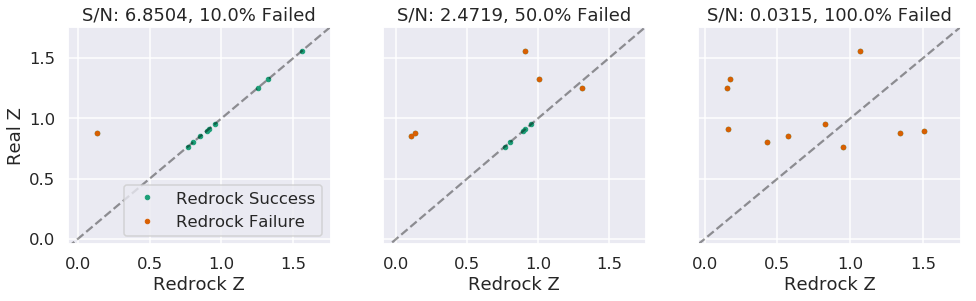

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(16,4), sharey=True)
ax[0].set_ylabel('Real Z')
ELGz = ELGmeta['REDSHIFT']

for i in range(len(reszbests)):
    
    reszbests[i]['dz'] = reszbests[i]['Z'] - ELGz
    rrfail = np.where(np.abs(reszbests[i]['dz']) > 0.003)
    failrate = len(reszbests[i][rrfail]) / len(reszbests[i])
    
    dlim = setlims(reszbests[i]['Z'], ELGz)
    
    ax[i].plot(reszbests[i]['Z'], ELGz, '.', label='Redrock Success')
    ax[i].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
    ax[i].plot(reszbests[i]['Z'][rrfail], ELGz[rrfail], '.', label='Redrock Failure')
    ax[i].set_xlim(dlim)
    ax[i].set_ylim(dlim)
    ax[i].set_xlabel('Redrock Z')
    ax[i].title.set_text('S/N: {}, {}% Failed'.format(sn[i], failrate*100))
ax[0].legend(loc='lower right')

In [ ]:
for ii in range(len(reszbests)):
    
    reszbests[ii]['dz'] = reszbests[ii]['Z'] - ELGz
    
    rrfail = np.where(np.abs(reszbests[ii]['dz']) > 0.003)
    
    failrate = len(reszbests[ii][rrfail]) / len(reszbests[ii])
    
    print('{}% of {} Failed'.format(failrate*100, zfiles[ii][len(fileloc)+1:-8]))

In [ ]:
end = time.time()

print('Runtime: {}'.format(end-start))